In [12]:
import numpy as np
import matplotlib.pyplot as plt

from utils import *

In [13]:
train_path = 'Data/train'
val_path = 'Data/valid'

classN_train_path = train_path + "/normal/"
classA_train_path = train_path + "/adenocarcinoma/"
classL_train_path = train_path + "/large.cell.carcinoma/"
classS_train_path = train_path + "/squamous.cell.carcinoma/"
classN_valid_path = val_path + "/normal/"
classA_valid_path = val_path + "/adenocarcinoma/"
classL_valid_path = val_path + "/large.cell.carcinoma/"
classS_valid_path = val_path + "/squamous.cell.carcinoma/"

In [14]:
mean_sizes = []

print("CLASS: NORMAL")
mean_sizes.append(get_average_image_size(classN_train_path)[0])

print("\nCLASS: A")
mean_sizes.append(get_average_image_size(classA_train_path)[0])

print("\nCLASS: L")
mean_sizes.append(get_average_image_size(classL_train_path)[0])

print("\nCLASS: S")
mean_sizes.append(get_average_image_size(classS_train_path)[0])

CLASS: NORMAL
n7 (2) - Copy.png corrupt
n7 - Copy.png corrupt
n7 (2).png corrupt
n7.png corrupt
Average Image Sizes
    mean:   (428.72222222222223, 571.4722222222222)
    median: (475.0, 562.0)

CLASS: A
Average Image Sizes
    mean:   (258.26666666666665, 385.574358974359)
    median: (256.0, 388.0)

CLASS: L
Average Image Sizes
    mean:   (259.7391304347826, 398.5304347826087)
    median: (261.0, 406.0)

CLASS: S
Average Image Sizes
    mean:   (271.3806451612903, 396.5032258064516)
    median: (274.0, 404.0)


In [15]:
mean_sizes = np.array(mean_sizes)
out_img_size = (int(np.round(mean_sizes[:, 0].mean())), int(np.round(mean_sizes[:, 1].mean())))

print(f"Mean of all images: {out_img_size}")

Mean of all images: (305, 438)


In [16]:
out_img_dir = "Data_Cropped_and_Resized"
output_img_size = (256, 256)

crop_and_resize_images(train_path, output_img_size, out_img_dir)

In [17]:
crop_and_resize_images(val_path, output_img_size, out_img_dir)


### Define class labels

In [18]:
class_mappings = {
    0: "normal",
    1: "adenocarcinoma",
    2: "large.cell.carcinoma",
    3: "squamous.cell.carcinoma"
}

### Feature Extraction

In [19]:
#train_path = "/content/drive/MyDrive/W281/Final Project/Data_Resized/train"
train_path = 'Data_Cropped_and_Resized/train'
train_imgs, train_sobel_edges, train_labels = extract_features(train_path, detect_edges_sobel, class_mappings)
_, train_hounsfield_edges, _ = extract_features(train_path, apply_hounsfield_units, class_mappings)
#_, train_binary_mask, _ = extract_features(train_path, binary_mask, class_mappings)


In [20]:
valid_path = "Data_Cropped_and_Resized/valid"
valid_imgs, valid_sobel_edges, valid_labels = extract_features(valid_path, detect_edges_sobel, class_mappings)
_, valid_hounsfield_edges, _ = extract_features(valid_path, apply_hounsfield_units, class_mappings)
#_, valid_binary_mask, _ = extract_features(valid_path, binary_mask, class_mappings)


### Plot features

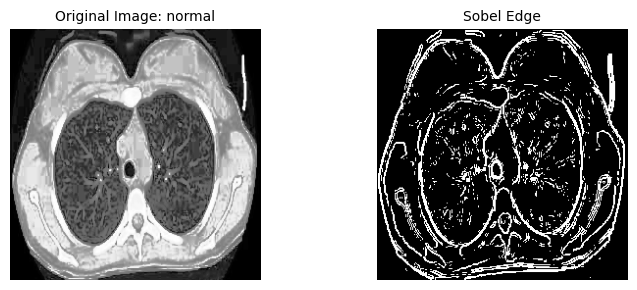

In [21]:
plot_features(train_imgs, train_sobel_edges, train_labels, 0, 'Sobel Edge', class_mappings)

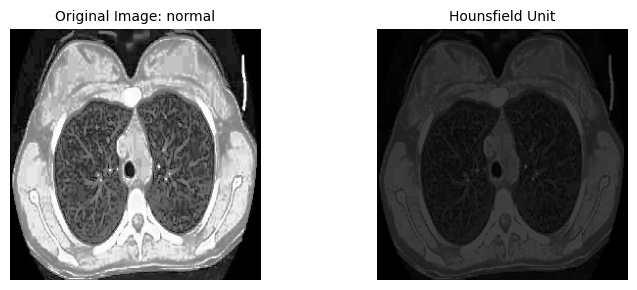

In [22]:
plot_features(train_imgs, train_hounsfield_edges, train_labels, 0, "Hounsfield Unit", class_mappings)

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC


def get_PCA(X_list, n_components=2):
  pca_list = []
  xpca_list = []
  for X in X_list:
    pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X)
    X_pca = pca.transform(X)
    pca_list.append(pca)
    xpca_list.append(X_pca)
  return pca_list, xpca_list

def plot_PCA(X_list, labels, n_components=2):
  pca_list, xpca_list = get_PCA(X_list, n_components=n_components)

  plt.figure(figsize=(15,5))
  colors = ['b-', 'm-', 'r-']
  for i in range(len(X_list)):
    plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=labels[i])
  plt.xticks(np.arange(n_components)+1)
  plt.yticks(np.linspace(0, 1, 8))
  plt.grid(True)
  plt.xlabel('Number of components')
  plt.ylabel('Explained Variances')
  plt.legend()
  plt.show()

def get_tsne(X_list, n_components=2):
  xtsne_list = []
  for X in X_list:
    tsne = TSNE(n_components=n_components, random_state=0)
    X_tsne = tsne.fit_transform(X)
    xtsne_list.append(X_tsne)
  return xtsne_list

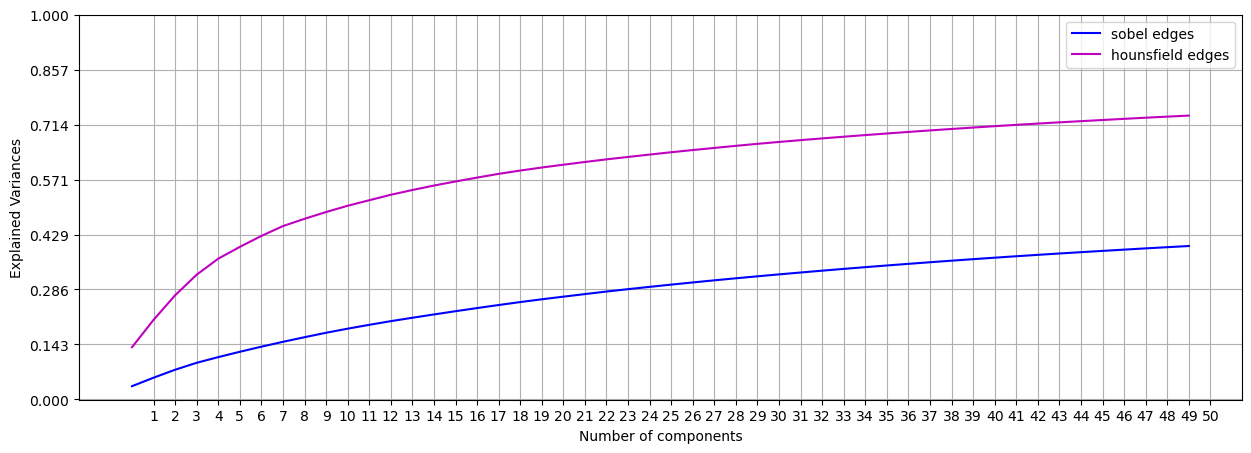

In [24]:

labels = ['sobel edges', 'hounsfield edges']

training_features = [[img.flatten() for img in train_sobel_edges],
            [img.flatten() for img in train_hounsfield_edges]]

valid_features = [[img.flatten() for img in valid_sobel_edges],
            [img.flatten() for img in valid_hounsfield_edges]]

x = plot_PCA(training_features, labels, n_components=50)

In [25]:
pca_list, xpca_list = get_PCA(training_features, n_components=49)

# Assign each PCA-transformed feature set to the respective variable
X_sobel_pca = xpca_list[0]
X_hounsfield_pca = xpca_list[1]

pca_list, xpca_list = get_PCA(valid_features, n_components=49)

# Assign each PCA-transformed feature set to the respective variable
X_sobel_pca_test = xpca_list[0]
X_hounsfield_pca_test = xpca_list[1]


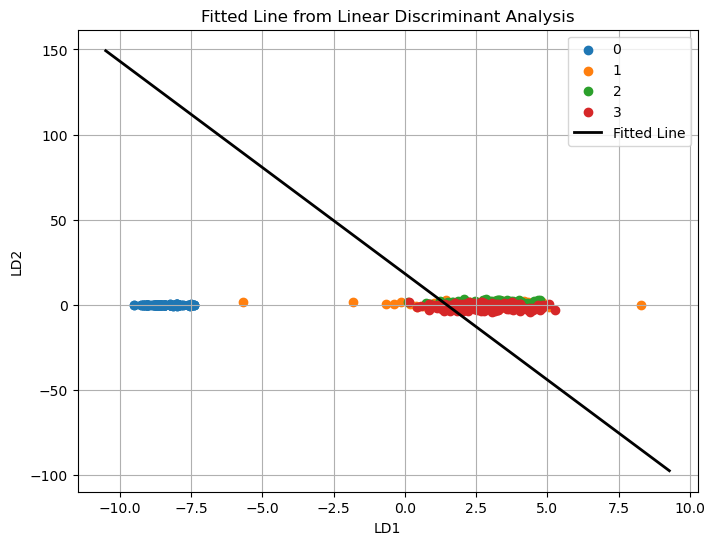

In [26]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
lda = LinearDiscriminantAnalysis()
lda.fit(X_sobel_pca, train_labels)

X_lda = lda.transform(X_sobel_pca)

coef_lda = lda.coef_[0]
intercept_lda = lda.intercept_[0]

plt.figure(figsize=(8, 6))

for label in np.unique(train_labels):
    plt.scatter(X_lda[train_labels == label, 0], X_lda[train_labels == label, 1], label=label)

line_x = np.array([X_lda[:, 0].min() - 1, X_lda[:, 0].max() + 1])
line_y = -(line_x * coef_lda[0] + intercept_lda) / coef_lda[1]

plt.plot(line_x, line_y, c='black', linewidth=2, label='Fitted Line')

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('Fitted Line from Linear Discriminant Analysis')
plt.legend()
plt.grid(True)
plt.show()

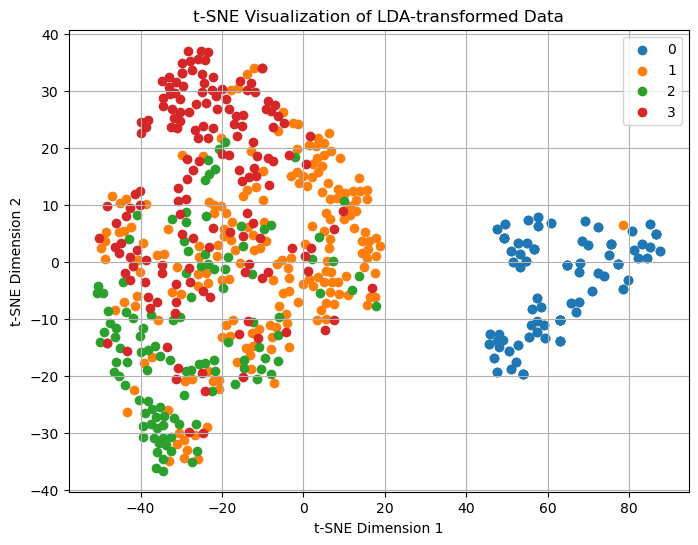

In [27]:

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_lda)

plt.figure(figsize=(8, 6))

for label in np.unique(train_labels):
    plt.scatter(X_tsne[train_labels == label, 0], X_tsne[train_labels == label, 1], label=label)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of LDA-transformed Data')
plt.legend()
plt.grid(True)
plt.show()


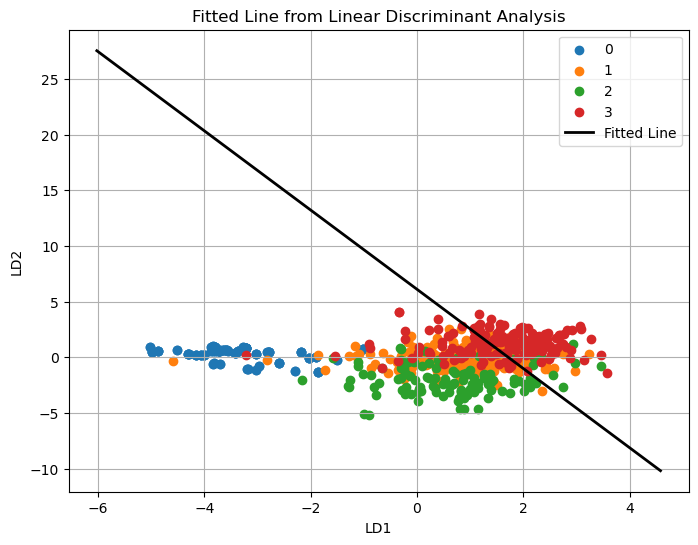

In [28]:

lda = LinearDiscriminantAnalysis()
lda.fit(X_hounsfield_pca, train_labels)

X_lda = lda.transform(X_hounsfield_pca)

coef_lda = lda.coef_[0]
intercept_lda = lda.intercept_[0]

plt.figure(figsize=(8, 6))

for label in np.unique(train_labels):
    plt.scatter(X_lda[train_labels == label, 0], X_lda[train_labels == label, 1], label=label)

line_x = np.array([X_lda[:, 0].min() - 1, X_lda[:, 0].max() + 1])
line_y = -(line_x * coef_lda[0] + intercept_lda) / coef_lda[1]

plt.plot(line_x, line_y, c='black', linewidth=2, label='Fitted Line')

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('Fitted Line from Linear Discriminant Analysis')
plt.legend()
plt.grid(True)
plt.show()

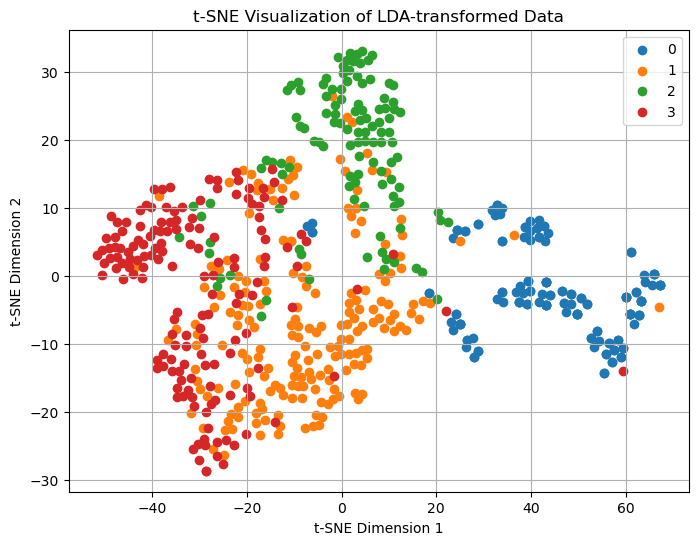

In [29]:

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_lda)

plt.figure(figsize=(8, 6))

for label in np.unique(train_labels):
    plt.scatter(X_tsne[train_labels == label, 0], X_tsne[train_labels == label, 1], label=label)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of LDA-transformed Data')
plt.legend()
plt.grid(True)
plt.show()


# LDA CLASSIFIER WITH PCA

In [30]:
!pip install seaborn


In [44]:
len(valid_labels)

72

Accuracy: 0.3888888888888889


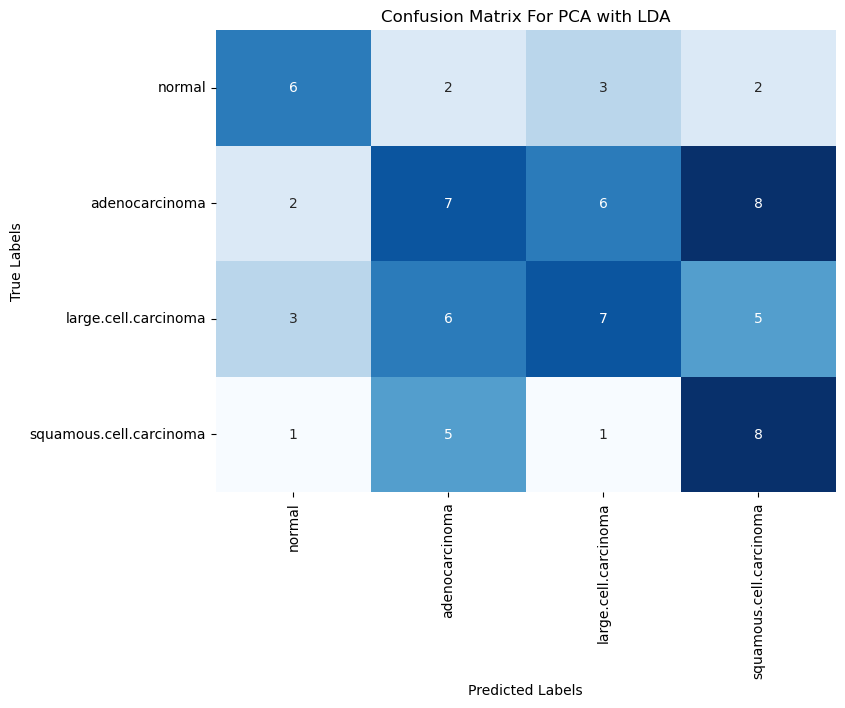

In [48]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

X_train = [np.array([x, y]).flatten() for x, y in zip(X_sobel_pca, X_hounsfield_pca)]
X_val = [np.array([x, y]).flatten() for x, y in zip(X_sobel_pca_test, X_hounsfield_pca_test)]

lda_classifier = LinearDiscriminantAnalysis()

lda_classifier.fit(X_train, train_labels)

y_pred = lda_classifier.predict(X_val)

# Calculate accuracy and confusion matrix
accuracy = accuracy_score(valid_labels, y_pred)

print("Accuracy:", accuracy)
# Generate the confusion matrix
conf_matrix = confusion_matrix(valid_labels, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=[class_mappings[i] for i in range(len(class_mappings))],
            yticklabels=[class_mappings[i] for i in range(len(class_mappings))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For PCA with LDA')
plt.show()


## LDA alone

Accuracy: 0.5972222222222222


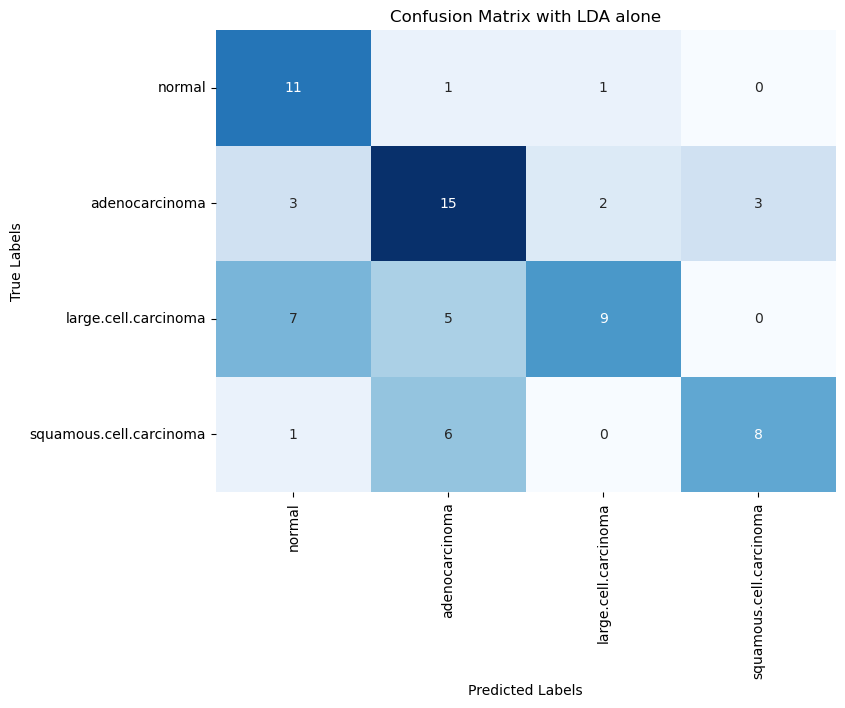

In [47]:

X_train = [np.array([x, y]).flatten() for x, y in zip(train_sobel_edges, train_hounsfield_edges)]
X_val = [np.array([x, y]).flatten() for x, y in zip(valid_sobel_edges, valid_hounsfield_edges)]

lda_classifier = LinearDiscriminantAnalysis()

# Train the LDA classifier on the training data
lda_classifier.fit(X_train, train_labels)

y_pred = lda_classifier.predict(X_val)

# Calculate accuracy and confusion matrix
accuracy = accuracy_score(valid_labels, y_pred)
conf_matrix = confusion_matrix(valid_labels, y_pred)

print("Accuracy:", accuracy)
conf_matrix = confusion_matrix(valid_labels, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=[class_mappings[i] for i in range(len(class_mappings))],
            yticklabels=[class_mappings[i] for i in range(len(class_mappings))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with LDA alone')
plt.show()

# LDA with nonlinear SVM

Accuracy: 0.3333333333333333


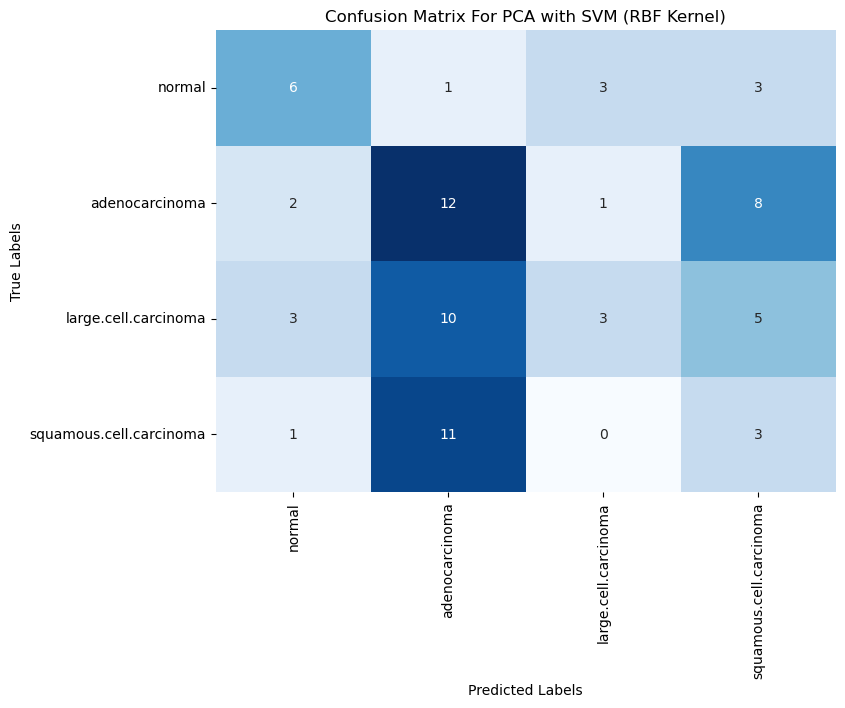

In [46]:
from sklearn.svm import SVC

X_train = [np.array([x, y]).flatten() for x, y in zip(X_sobel_pca, X_hounsfield_pca)]
X_val = [np.array([x, y]).flatten() for x, y in zip(X_sobel_pca_test, X_hounsfield_pca_test)]

# Create a nonlinear SVM classifier with RBF kernel
svm_classifier = SVC(kernel='rbf')

svm_classifier.fit(X_train, train_labels)

y_pred = svm_classifier.predict(X_val)

# Calculate accuracy and confusion matrix
accuracy = accuracy_score(valid_labels, y_pred)

print("Accuracy:", accuracy)

# Generate the confusion matrix
conf_matrix = confusion_matrix(valid_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=[class_mappings[i] for i in range(len(class_mappings))],
            yticklabels=[class_mappings[i] for i in range(len(class_mappings))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For PCA with SVM (RBF Kernel)')
plt.show()


# LDA with SVM

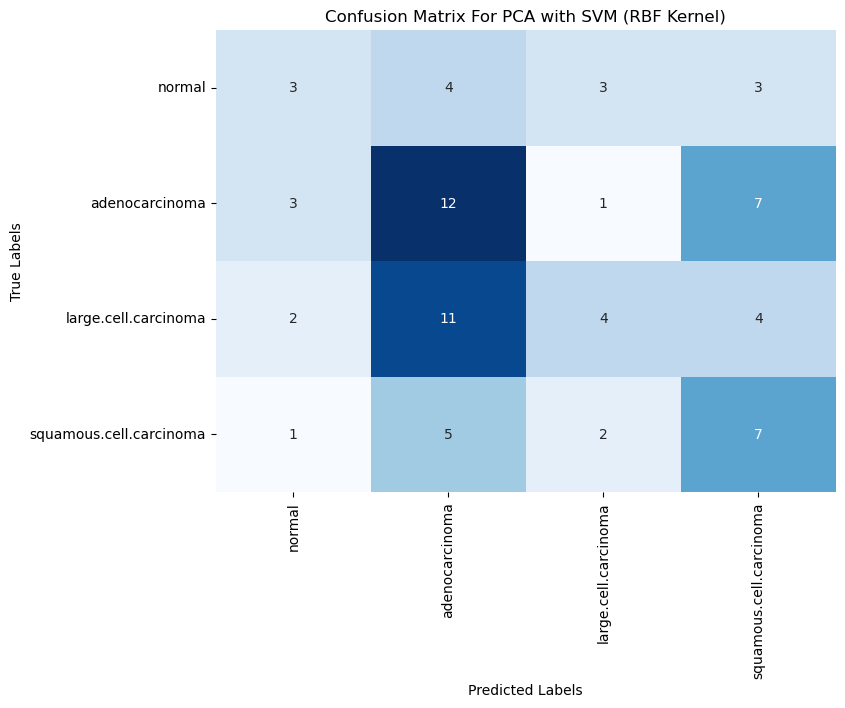

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

# ... Your existing code ...

# Generate the confusion matrix
conf_matrix = confusion_matrix(valid_labels, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=[class_mappings[i] for i in range(len(class_mappings))],
            yticklabels=[class_mappings[i] for i in range(len(class_mappings))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For PCA with SVM (RBF Kernel)')
plt.show()


# Testing Morphological operations 

Python OpenCV Morphological operations are one of the Image processing techniques that processes image based on shape. This processing strategy is usually performed on binary images. For all the above techniques the two important requirements are the binary image and a kernel structuring element that is used to slide across the image.

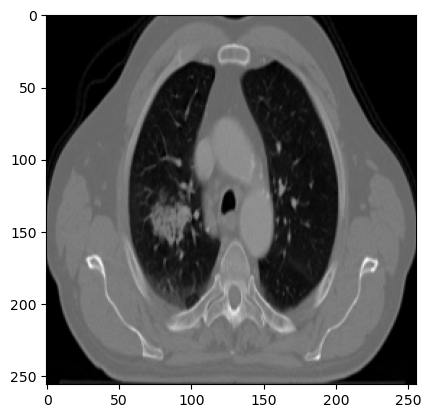

In [35]:
img = cv2.imread(r"Data_Cropped_and_Resized/train/adenocarcinoma/000036 (7).png", 0)
plt.imshow(img, cmap='gray')


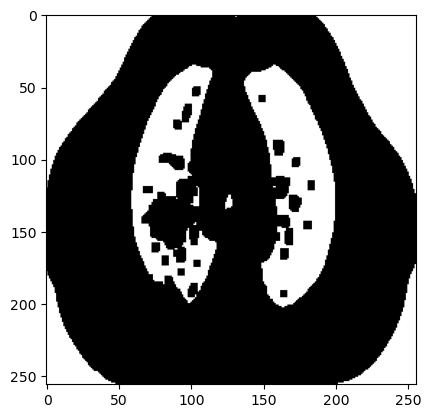

In [36]:
# import the necessary packages
import cv2
import numpy as np
import matplotlib.pyplot as plt

# read the image
img = cv2.imread(r"Data_Cropped_and_Resized/train/adenocarcinoma/000036 (7).png", 0)

# binarize the image
binr = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

# define the kernel
kernel = np.ones((5, 5), np.uint8)

# invert the image
invert = cv2.bitwise_not(binr)

# erode the image
erosion = cv2.erode(invert, kernel,
					iterations=1)

# print the output
plt.imshow(erosion, cmap='gray')


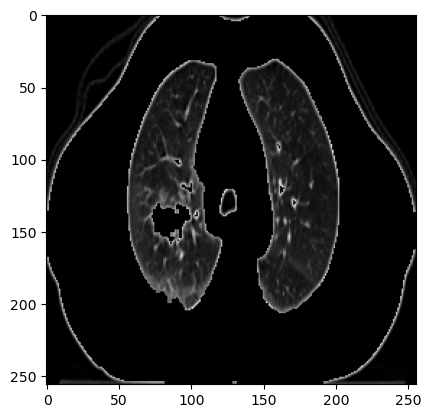

In [37]:
# read the image
img = cv2.imread(r"Data_Cropped_and_Resized/train/adenocarcinoma/000036 (7).png", 0)

# binarize the image
binr = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

# define the kernel
kernel = np.ones((3, 3), np.uint8)

# invert the image
invert = cv2.bitwise_not(binr)

# dilate the image
dilation = cv2.dilate(invert, kernel, iterations=1)

# combine the lung mask with image, keeping only pixels that correspond lungs 
lung_image = cv2.bitwise_and(img, img, mask=dilation)

# print the output
plt.imshow(lung_image, cmap='gray')



In [38]:
import os
import glob

# Define the path to the directory containing the images
image_directory = "Data_Cropped_and_Resized/train/adenocarcinoma/"

# Get a list of all image file paths in the directory
image_files = glob.glob(os.path.join(image_directory, "*.png"))

# Create a directory to store the output images
output_directory = "output_images_dilation/"
os.makedirs(output_directory, exist_ok=True)

# Loop through each image
for image_file in image_files:
    # Read the image
    img = cv2.imread(image_file, 0)

    # Binarize the image
    binr = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Define the kernel
    kernel = np.ones((5, 5), np.uint8)

    # invert the image
    invert = cv2.bitwise_not(binr)
    
    # dilate the image
    dilation = cv2.dilate(invert, kernel, iterations=1)
    
    # convert all the black pixels to white and vice versa
    lung_mask = cv2.bitwise_not(dilation)

    # combine the lung mask with image, keeping only pixels that correspond lungs 
    lung_image = cv2.bitwise_and(img, img, mask=lung_mask)

    # Save the processed image in the output directory
    filename = os.path.basename(image_file)
    output_path = os.path.join(output_directory, filename)
    cv2.imwrite(output_path, lung_image)


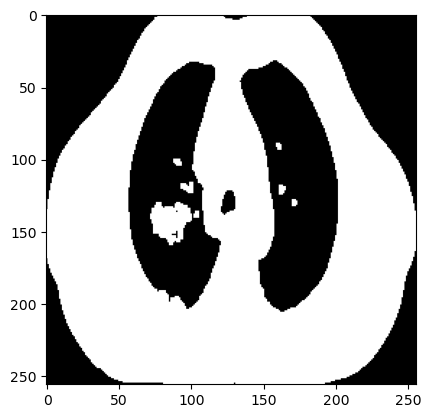

In [39]:
# read the image
img = cv2.imread(r"Data_Cropped_and_Resized/train/adenocarcinoma/000036 (7).png", 0)

# binarize the image
binr = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

# define the kernel
kernel = np.ones((3, 3), np.uint8)

# invert the image
invert = cv2.bitwise_not(binr)

opening = cv2.morphologyEx(binr, cv2.MORPH_OPEN,
						kernel, iterations=1)

plt.imshow(opening, cmap='gray')


In [40]:
import os
import cv2
import numpy as np
import glob

# Define the path to the directory containing the images
image_directory = "Data_Cropped_and_Resized/train/adenocarcinoma/"

# Get a list of all image file paths in the directory
image_files = glob.glob(os.path.join(image_directory, "*.png"))

# Create a directory to store the output images
output_directory = "output_images/"
os.makedirs(output_directory, exist_ok=True)

# Loop through each image
for image_file in image_files:
    # Read the image
    img = cv2.imread(image_file, 0)

    # Binarize the image
    binr = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Define the kernel
    kernel = np.ones((5, 5), np.uint8)

    # Opening the image
    opening = cv2.morphologyEx(binr, cv2.MORPH_OPEN, kernel, iterations=1)

    # convert all the black pixels to white and vice versa
    lung_mask = cv2.bitwise_not(opening)

    # combine the lung mask with image, keeping only pixels that correspond lungs 
    lung_image = cv2.bitwise_and(img, img, mask=lung_mask)

    # Save the processed image in the output directory
    filename = os.path.basename(image_file)
    output_path = os.path.join(output_directory, filename)
    cv2.imwrite(output_path, lung_image)


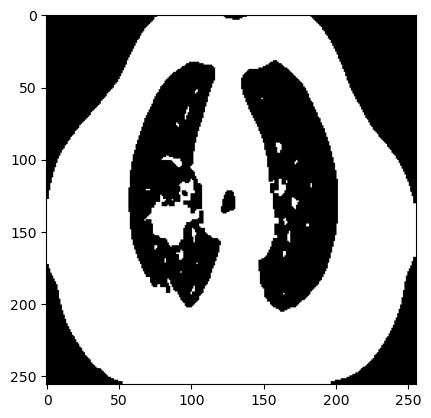

In [41]:
img = cv2.imread(r"Data_Cropped_and_Resized/train/adenocarcinoma/000036 (7).png", 0)

# binarize the image
binr = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

# define the kernel
kernel = np.ones((3, 3), np.uint8)

closing = cv2.morphologyEx(binr, cv2.MORPH_CLOSE, kernel, iterations=1)
plt.imshow(closing, cmap='gray')


# Try to detect blobs with Masked Images

In [42]:
! pip install opencv-python

In [43]:
import os
import cv2
import numpy as np
import glob

# Define the path to the directory containing the images
image_directory = "output_images/"

image_files = glob.glob(os.path.join(image_directory, "*.png"))

# Create a directory to store the output images
output_directory = "output_images_blob/"
os.makedirs(output_directory, exist_ok=True)

min_threshold = 150
max_threshold = 255

params = cv2.SimpleBlobDetector_Params()

params.filterByArea = True
params.minArea = 10
params.maxArea = 130635
    
params.filterByCircularity = True
params.minCircularity = 0.7 
params.filterByInertia = False

params.filterByConvexity = True
params.minConvexity = 0.7  

detector = cv2.SimpleBlobDetector_create(params)


# Loop through each image
for image_file in image_files:
    img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

    # Detect blobs in the image
    keypoints = detector.detect(img)

    # Draw blobs on the image
    img_with_blobs = cv2.drawKeypoints(img, keypoints, np.array([]), (0, 0, 255),
                                       cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    filename = os.path.basename(image_file)
    output_path = os.path.join(output_directory, filename)
    cv2.imwrite(output_path, img_with_blobs)